In [1]:
import pandas as pd
import numpy as np 
import string
import tqdm
import spacy
import matplotlib.pyplot as plt

--------

### Get the embeddings

In [2]:
nlp = spacy.load('fr_core_news_sm')

def lemmatisation(text):
    doc = nlp(str(text))
    lemma = ''
    for token in doc:
        lemma += token.lemma_ + ' '
    return lemma

res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    
data = pd.read_csv('../data/dataset_1.csv')

# Let's lemmatise the dataset : WARNING, it takes about 11 min !!, take a break and drink some coffee ;-)
new_data = pd.DataFrame(np.copy(data), columns=data.columns)
for i in tqdm.tqdm(range(len(data))):
    new_data['solution'][i] = lemmatisation(new_data['solution'][i])
    
data = new_data

100%|██████████| 15309/15309 [10:55<00:00, 23.35it/s]


--------

### Compute variance and distance for argumentation

In [3]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

In [4]:
def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    words = sentence.split(' ')
    words = list(set(words))
    for i, word in enumerate(words):
        try : 
            if embeded_words[word].endswith('_n'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    # Could be interesting to add a cosine evaluation !
    # Or count the clusters which are concerned by the sentence.
    # (after clustering of the embeddings -> use a grid_search or dendrograms.)
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

In [5]:
data.head(5)

,Unnamed: 0,zip_code,problem,solution
0,1,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...
1,5,95330,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...
2,6,84750,La biodiversité et la disparition de certaines...,"Arrêter les pesticides , notamment le glyphosa..."
3,10,33820,La pollution de l'air,- Réduire de manière drastique les déplacement...
4,14,8500,Pollution air et mers,Interdire très rapidement les emballages plast...


###### Quick look at the sentences and some results

In [6]:
n_print = 15
for i in range(n_print): 
    sentence = data.iloc[i]['solution']
    print(preprocess(sentence))
    print('Variance = ',compute_variance(embed_answer(sentence),eval_type='var'))
    print('Distance = ',compute_variance(embed_answer(sentence),eval_type='dist'))
    
    words = sentence.split(' ')
    words = list(set(words))
    embedded_words = []
    for i, word in enumerate(words):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

les problèmes auxquels se trouve confronté l’ensemble de la planète et que dénoncent dans le plus parfait désordre les gilets jaunes de france ne sontils pas dus avant tout à la surpopulation mondiale  cette population est passée d’15 milliards d’habitants en 1900 à 7 milliards en 2020 et montera bientôt à 10 milliards vers 2040  avec les progrès de la communication dans ce village mondial chaque individu du fin fond de l’asie au fin fond de l’afrique en passant par les « quartiers » et les « campagnes » de notre pays aspire à vivre – et on ne peu l’en blâmer – comme les moins mal lotis de nos concitoyens logement nourriture biens de consommation déplacementetc  voilà la mère de tous les problèmes si tel est bien le cas la solution à tous les problèmes stabilisation de la croissance démographique partage des richesses partage des terres partage de l’eau protection de la biodiversité règlement des conflits lutte contre la déforestation lutte contre dérèglement climatique règlement des c

Variance =  5.845389990976221
Distance =  4.182971960924974
Embedded words :  ['production', 'commercialisation', 'la']
----------------------------------------------------------------------------------------------------
imposer à des constructeurs automobiles d’accélérer les recherches le développement et le déploiement de véhicules à hydrogène pour une mise en circulation le plus rapidement possible en faire une ambition nationale pour que la france soit le leader mondial dans ce domaine
dans les villes hors paris rendre les transports en commun de proximité gratuits ou à tarifs réduits
Variance =  12.574363746941032
Distance =  5.210495477314124
Embedded words :  ['déploiement', 'mise', 'hydrogène', 'proximité', 'ambition', 'circulation', 'commun', 'leader', 'la', 'développement']
----------------------------------------------------------------------------------------------------
il faut que l effort à la transition écologique soit évalué équitablement citoyens grandes entreprises i

--------

### Let's apply it to the whole dataset, we only focus on the solution proposed

In [11]:
scores = []
word_counter = []
freq = []

for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        scores.append([compute_variance(answer, eval_type='var'),
                       compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan, np.nan])
        
    sentence = preprocess(data.iloc[index]['solution'])
    words = sentence.split(' ')
    words = list(set(words))
    embedded_wds = []
    for i, word in enumerate(words):
        try : 
            if embeded_words[word].endswith('_n'):
                embedded_wds.append(word)
        except KeyError: 
            continue
    nb_words = len(embedded_wds)
    word_counter.append(nb_words)
    
unique_nb_words = np.unique(word_counter, return_counts=True)
nb_words_occ = {}
for nb_words, occ in zip(unique_nb_words[0],unique_nb_words[1]):
    nb_words_occ[nb_words] = occ
    
for nb_words in word_counter:
    freq.append(nb_words_occ[nb_words])
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns=['Variance', 'Distance'])
word_counter_df = pd.DataFrame(data=np.array(word_counter),index=data.index, columns=['Nb_words'])
freq_df = pd.DataFrame(data=np.array(freq),index=data.index, columns=['Freq'])
argumentation_scores = pd.concat([data['zip_code'], scores_df, word_counter_df, freq_df], axis=1)
argumentation_scores.head(5)


  2%|▏         | 342/15309 [00:22<18:44, 13.31it/s]


  4%|▍         | 663/15309 [00:45<16:15, 15.02it/s]


  7%|▋         | 1004/15309 [01:17<15:07, 15.76it/s]


  9%|▉         | 1353/15309 [01:40<11:57, 19.46it/s]


 11%|█         | 1704/15309 [02:02<15:23, 14.73it/s]


 13%|█▎        | 2064/15309 [02:24<13:52, 15.90it/s]


 16%|█▌        | 2397/15309 [02:46<11:50, 18.17it/s]


 18%|█▊        | 2735/15309 [03:08<15:11, 13.80it/s]


 20%|██        | 3099/15309 [03:33<11:45, 17.31it/s]


 23%|██▎       | 3455/15309 [03:55<11:24, 17.31it/s]


 25%|██▌       | 3832/15309 [04:18<09:47, 19.53it/s]


 27%|██▋       | 4195/15309 [04:41<12:54, 14.35it/s]


 30%|███       | 4606/15309 [05:03<09:10, 19.46it/s]


 33%|███▎      | 5009/15309 [05:25<12:04, 14.22it/s]


 35%|███▌      | 5409/15309 [05:46<13:14, 12.46it/s]


 38%|███▊      | 5800/15309 [06:08<07:55, 20.01it/s]


 40%|████      | 6199/15309 [06:31<07:33, 20.08it/s]


 43%|████▎     | 6580/15309 [06:53<06:18, 23.05it/s]


 46%|████▌     | 6988/15309 [07:15<08:06, 17.10it/s]


 48%|████▊     | 7396/15309 [07:37<06:29, 20.30it/s]


 51%|█████     | 7785/15309 [08:00<06:42, 18.69it/s]


 54%|█████▎    | 8194/15309 [08:23<06:16, 18.90it/s]


 56%|█████▌    | 8565/15309 [08:45<12:55,  8.69it/s]


 58%|█████▊    | 8944/15309 [09:06<05:04, 20.88it/s]


 61%|██████    | 9340/15309 [09:27<05:20, 18.61it/s]


 64%|██████▎   | 9748/15309 [09:50<04:37, 20.05it/s]


 66%|██████▌   | 10125/15309 [10:13<04:09, 20.80it/s]


 69%|██████▊   | 10498/15309 [10:35<09:01,  8.88it/s]


 71%|███████   | 10847/15309 [10:56<04:09, 17.89it/s]


 73%|███████▎  | 11240/15309 [11:19<05:05, 13.30it/s]


 76%|███████▌  | 11617/15309 [11:40<03:02, 20.20it/s]


 78%|███████▊  | 12009/15309 [12:01<03:01, 18.15it/s]


 81%|████████  | 12407/15309 [12:22<03:22, 14.36it/s]


 84%|████████▎ | 12788/15309 [12:43<02:49, 14.89it/s]


 86%|████████▌ | 13161/15309 [13:04<01:50, 19.43it/s]


 88%|████████▊ | 13538/15309 [13:28<02:57,  9.98it/s]


 91%|█████████ | 13898/15309 [13:49<01:19, 17.83it/s]


 93%|█████████▎| 14267/15309 [14:10<00:56, 18.28it/s]


 96%|█████████▌| 14641/15309 [14:31<00:38, 17.33it/s]


 98%|█████████▊| 15021/15309 [14:53<00:18, 15.49it/s]


100%|██████████| 15309/15309 [15:09<00:00, 16.84it/s]


,zip_code,Variance,Distance,Nb_words,Freq
0,57000,13.492236,5.200961,263,11
1,95330,12.614204,5.007380,449,1
2,84750,12.805894,5.116135,93,73
3,33820,13.407533,5.260951,73,124
4,8500,12.127912,4.992264,84,101


--------

### Etudier les raisons des valeurs extrêmes

In [12]:
values = argumentation_scores['Variance'].dropna().values
interesting_data = data.drop(argumentation_scores['Variance'].index[argumentation_scores['Variance'].apply(np.isnan)])
percentile = np.percentile(abs(values),99) # A tester avec 1 et < dans la ligne au dessous
interesting_values = values[abs(values)>percentile]
interesting_sentences = interesting_data[abs(values)<percentile]['solution']
for index in range(len(interesting_values)):
    sentence = preprocess(interesting_sentences.iloc[index])
    print(sentence)
    print('Variance = ', interesting_values[index])
    embedded_words = []
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

le problème auxquel se trouve confronter l’ ensemble de le planète et que dénoncer  dans le plus parfait désordre  le gilet jaune de france ne être  il pas dus  avant tout  à le surpopulation mondial  ce population être passer d’15 milliard d’ habitant en 1900 à 7 milliard en 2020 et monter bientôt à 10 milliard vers 2040    avec le progrès de le communication dans ce village mondial  chaque individu  de fin fond de l’ asie au fin fond de l’ afrique  en passer par le « quartiers » et le « campagne » de notre pays  aspir à vivre – et on ne peu l’ en blâmer – comme le moins mal lotir de notre concitoyen  logement  nourriture  bien de consommation  déplacement  etc      voilà le mère de tout le problème  si tel être bien le cas  le solution à tout le problème  stabilisation de le croissance démographique  partage un richesse  partage un terre  partage de l’ eau  protection de le biodiversité  règlement un conflit  lutte contre le déforestation  lutte contre dérèglement climatique  règleme

obliger le commune et regroupemer de commune avoir partir de 10 000 habitant avoir créer un usine de méthanisation pour faire de le électricité ou de chauffage collectif  au lieu de mettre un camion de ramassage sur le route  savoir que le déchet ultime aprés tamisage pouvoir servir de fertiliser 
Variance =  15.42805875486845
Embedded words :  ['commune', 'commune', 'habitant', 'un', 'usine', 'méthanisation', 'électricité', 'chauffage', 'collectif', 'lieu', 'un', 'camion', 'ramassage', 'route', 'déchet']
----------------------------------------------------------------------------------------------------
mettre le camion sur rails 
 travailler avoir le maison pour celui qui le pouvoir 
 consommer local  exemple  on trouve un oignon de nouveau zélande   en supermarché  
 taxer le déplacement non prioritaire avion bateau de croisière etc  
Variance =  18.74715183490118
Embedded words :  ['camion', 'maison', 'local', 'exemple', 'un', 'oignon', 'nouveau', 'supermarché', 'déplacement', 'avi

--------

### Normalisation of the values

In [87]:
with_counter = pd.concat([argumentation_scores, pd.DataFrame(np.array(word_counter))], axis=1)

# Then, let's compute the mean and variance values of the variances (resp. distance) 
# with respect to the number of words.
normalized_scores = pd.DataFrame(np.copy(argumentation_scores), columns=argumentation_scores.columns)

unique_word_nb = np.unique(word_counter, return_counts=True)
for word_nb, freq in zip(unique_word_nb[0],unique_word_nb[1]):
    for eval_type in ['Variance', 'Distance']:
        if freq>1:
            corresponding_values=[]
            indexes=[]
            for idx in np.where(np.array(word_counter)==word_nb)[0]:
                if not np.isnan(argumentation_scores.iloc[idx][eval_type]): 
                    # If only one word or less is embedded, then the variance and distance value are nan
                    # and we mustn't consider them in the normalisation...
                    corresponding_values.append(argumentation_scores.iloc[idx][eval_type])
                    indexes.append(idx)

            mean_value = np.mean(corresponding_values)
            var_value = np.var(corresponding_values)

            for idx in indexes:
                normalized_scores.iloc[idx][eval_type] -= mean_value
                normalized_scores.iloc[idx][eval_type] /= var_value
                
normalized_scores.columns = ['zip_code','Variance_std','Distance_std','Nb_words','Freq']




  0%|          | 0/15309 [00:00<?, ?it/s]


  1%|          | 172/15309 [00:00<00:08, 1696.07it/s]


  2%|▏         | 302/15309 [00:00<00:09, 1553.85it/s]


  3%|▎         | 458/15309 [00:00<00:09, 1554.05it/s]


  4%|▍         | 598/15309 [00:00<00:09, 1503.90it/s]


  5%|▍         | 717/15309 [00:00<00:10, 1393.14it/s]


  5%|▌         | 831/15309 [00:00<00:11, 1302.18it/s]


  6%|▌         | 945/15309 [00:00<00:12, 1136.41it/s]


  7%|▋         | 1051/15309 [00:00<00:14, 1003.66it/s]


  8%|▊         | 1184/15309 [00:00<00:13, 1082.14it/s]


  9%|▊         | 1324/15309 [00:01<00:12, 1160.26it/s]


  9%|▉         | 1442/15309 [00:01<00:12, 1085.15it/s]


 10%|█         | 1574/15309 [00:01<00:11, 1146.31it/s]


 11%|█▏        | 1724/15309 [00:01<00:11, 1232.87it/s]


 12%|█▏        | 1869/15309 [00:01<00:10, 1290.46it/s]


 13%|█▎        | 2046/15309 [00:01<00:09, 1403.74it/s]


 14%|█▍        | 2192/15309 [00:01<00:09, 1418.10it/s]


 15%|█▌        | 2340/15309 [00:01<00:09, 1434.8

In [88]:
department = np.copy(normalized_scores['zip_code'].values)
for dpt_idx in range(len(department)):
    if department[dpt_idx]>=1 and department[dpt_idx]<=95:
        continue
    elif department[dpt_idx]>=1000 and department[dpt_idx]<96000:
        department[dpt_idx] = int(department[dpt_idx]/1000)

department_df = pd.DataFrame(department, columns=['Department'])

final_data = pd.concat([department_df, normalized_scores], axis=1)
final_data = final_data.dropna()
final_data['Freq'] = final_data['Freq'].astype(int)
final_data['Nb_words'] = final_data['Nb_words'].astype(int)
final_data['zip_code'] = final_data['zip_code'].astype(int)
final_data['Department'] = final_data['Department'].astype(int)
final_data = final_data[final_data['Department']>=1]
final_data = final_data[final_data['Department']<=95]

print(final_data.shape)
final_data.head()

(15128, 6)


,Department,zip_code,Variance_std,Distance_std,Nb_words,Freq
0,57,57000,0.367687,1.97516,263,11
1,95,95330,-2.40945,-12.8462,449,1
2,84,84750,0.136498,0.537683,93,73
3,33,33820,0.792396,4.09159,73,124
4,8,8500,-0.33539,-2.46286,84,101


In [32]:
len(np.unique(final_data['Department']))

95

--------

### Let's plot the histograms Occ=f(Var) and Occ=f(Dist) for the most represented departments

75 -0.06583512788550858 0.9833299580601875
69 0.021399217868628313 1.094557833285845
31 -0.05635952823618997 1.0756719567787796
13 0.009158246225005587 1.0493784330131066
92 -0.04038124081406002 0.9689980651311095
33 0.005400205250681368 1.0494910290930612
78 -0.01685556268852281 0.876989689399899
38 0.07191784744948022 0.8054148093495925
44 -0.06477229979154456 0.995725797794931
59 -0.0663021006410077 0.8541177692807961
34 0.09596589902630659 1.0099258526211383
94 -0.07332489890543159 0.9162761534072392
91 -0.05350812690744146 0.9055953813706232
83 0.12102658890837414 0.8651280412828406
6 0.030654807585997267 0.7420472179251245
77 0.06909352295275732 0.9935009012211716
35 -0.11998529767295853 1.1372004918324523
67 0.058976786917413135 0.963835426907269
74 -0.06619980366348714 0.7664879918770018
76 -0.004763067167931628 0.8790960800637538
29 -0.05895828725273608 0.8304865662612405
30 0.020876899843300403 1.0865652759335058
63 -0.054170314598382036 0.9340311121759963
1 0.072277021293925

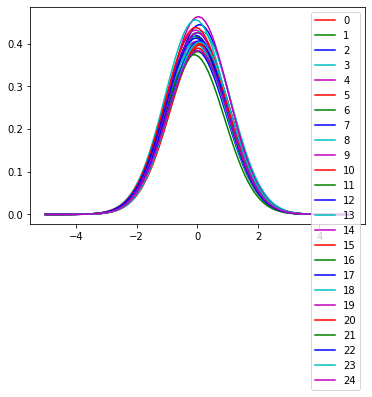

In [30]:
# Let's plot the hist for the most represented department
colors = ['r','g','b','c','m']
unique_dpt = np.unique(final_data['Department'], return_counts=True)
dpts = unique_dpt[0]
counts = unique_dpt[1]
for k in range(25):
    max_dpt_idx = np.argmax(counts)
    max_dpt = dpts[max_dpt_idx]

    values = final_data[final_data['Department']==max_dpt]['Variance_std'].dropna().values
    percentile = np.percentile(abs(values),95)
    valid_values = values[abs(values)<percentile]
    
    M = np.mean(valid_values)
    V = np.var(valid_values)
    print(max_dpt,M,V)
    gauss_pdf = lambda x,V,M: 1/np.sqrt(2*np.pi*V) * np.exp(-.5*(x-M)**2)
    X = np.linspace(-5,5,100)
    Y = []
    for elt in X:
        Y.append(gauss_pdf(elt,V,M))

    #final_data[final_data['Department']==max_dpt]['Variance_std'].hist(bins=2000, alpha=0.5)
    plt.plot(X,Y,color=colors[k%5],label=k)
    #plt.xlim(right=-5, left=5)
    #plt.ylim(bottom=0, top=2)
    counts = np.delete(counts,max_dpt_idx)
    dpts = np.delete(dpts,max_dpt_idx)
plt.legend()
plt.show()

--------

### Let's add the values to the dataframe

In [37]:
final_data[final_data['Department']==12]

,Department,zip_code,Variance_std,Distance_std,Nb_words,Freq
238,12,12100,-0.258502,-0.185602,73,124
506,12,12230,-1.13884,-5.54844,297,5
540,12,12700,0.019211,1.71585,90,80
736,12,12000,0.175414,1.66214,64,144
855,12,12200,-0.290107,-1.89558,47,237
...,...,...,...,...,...,...
13346,12,12000,1.90043,8.99394,75,111
13408,12,12740,-0.122349,1.0807,36,157
13843,12,12100,-1.12196,-5.52352,82,79
14446,12,12200,0.0607025,3.00888,42,274


In [40]:
unique_dpt = np.unique(final_data['Department'], return_counts=True)[0]
mapping = {'Variance_std':{},'Distance_std':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = final_data[final_data['Department']==dpt][eval_type].dropna().values
        try:
            percentile = np.percentile(abs(values),95)
            valid_values = values[abs(values)<=percentile]

            M = np.mean(valid_values)
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][dpt] = [M,V]
    
    
    try:
        final_data = final_data.drop(eval_type + '_mean_wrt_dpt', axis=1)
    except:
        pass
    means = []
    for index in final_data.index:
        means.append(mapping[eval_type][final_data['Department'][index]][0])

    means = pd.DataFrame(means, index=final_data.index, columns=[eval_type + '_mean_wrt_dpt'])
    final_data = pd.concat([final_data, means], axis=1)

--------

### Plot the cartographie of the scores

In [81]:
def plot_cartography(Colors, eval_type, figsize=(14, 14)):

    ####################################################
    ### Some weird code to plot the graph.
    ####################################################


    from pyensae import download_data
    import os
    try:
        download_data("../data/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z",
                      website="https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/" + \
                              "GEOFLA_THEME-DEPARTEMENTS_2015_2$GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/file/")
    except Exception as e:
        # au cas le site n'est pas accessible
        download_data("../data/GGEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", website="xd")

    ###################################################################################################

    from pyquickhelper.filehelper import un7zip_files
    try:
        un7zip_files("../data/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", where_to="shapefiles")
        departements = '../data/shapefiles/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/GEOFLA/1_DONNEES_LIVRAISON_2015/' + \
                       'GEOFLA_2-1_SHP_LAMB93_FR-ED152/DEPARTEMENT/DEPARTEMENT.shp'
    except FileNotFoundError as e:
        # Il est possible que cette instruction ne fonctionne pas.
        # Dans ce cas, on prendra une copie de ce fichier.
        import warnings
        warnings.warn("Plan B parce que " + str(e))
        download_data("DEPARTEMENT.zip")
        departements = "DEPARTEMENT.shp"

    if not os.path.exists(departements):
        raise FileNotFoundError("Impossible de trouver '{0}'\ncurrent folder: '{1}'".format(
            departements, os.getcwd()))

    ###################################################################################################

    shp = departements
    import shapefile
    r = shapefile.Reader(shp)
    shapes = r.shapes()
    records = r.records()
    len(shapes), len(records)


    ###################################################################################################

    import math

    def lambert932WGPS(lambertE, lambertN):

        class constantes:
            GRS80E = 0.081819191042816
            LONG_0 = 3
            XS = 700000
            YS = 12655612.0499
            n = 0.7256077650532670
            C = 11754255.4261

        delX = lambertE - constantes.XS
        delY = lambertN - constantes.YS
        gamma = math.atan(-delX / delY)
        R = math.sqrt(delX * delX + delY * delY)
        latiso = math.log(constantes.C / R) / constantes.n
        sinPhiit0 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * math.sin(1)))
        sinPhiit1 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit0))
        sinPhiit2 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit1))
        sinPhiit3 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit2))
        sinPhiit4 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit3))
        sinPhiit5 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit4))
        sinPhiit6 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit5))

        longRad = math.asin(sinPhiit6)
        latRad = gamma / constantes.n + constantes.LONG_0 / 180 * math.pi

        longitude = latRad / math.pi * 180
        latitude = longRad / math.pi * 180

        return longitude, latitude

    lambert932WGPS(99217.1, 6049646.300000001), lambert932WGPS(1242417.2, 7110480.100000001)


    ###################################################################################################

    from cartopy.feature import NaturalEarthFeature, COLORS
    resolution = "50m"
    BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                                  resolution, edgecolor='black', facecolor='none')
    STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                                 resolution, edgecolor='black', facecolor='none')
    COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                    edgecolor='black', facecolor='none')
    LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                                edgecolor='face',
                                facecolor=COLORS['water'])
    LAND = NaturalEarthFeature('physical', 'land', resolution,
                               edgecolor='face',
                               facecolor=COLORS['land'], zorder=-1)
    OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                                edgecolor='face',
                                facecolor=COLORS['water'], zorder=-1)
    RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                                 edgecolor=COLORS['water'],
                                 facecolor='none')


    ###################################################################################################
    
    ####################################################
    ### Plotting Variables
    ####################################################

    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import geoplot
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.add_feature(BORDERS)
    #ax.add_feature(LAKES)
    ax.add_feature(LAND)
    ax.add_feature(OCEAN)
    #ax.add_feature(RIVERS)
    ax.add_feature(COASTLINE)
    ax.set_extent([-5, 12, 40, 54])
    ax.set_title("French Departments, colors correpond to the mean of the argumentation scores : " + eval_type)
    #ax.gridlines(crs=projection, draw_labels=True,
    #             linewidth=2, color='gray', alpha=0.5, linestyle='--')

    from matplotlib.collections import LineCollection
    import shapefile
    import geopandas
    from shapely.geometry import Polygon
    from shapely.ops import cascaded_union, unary_union
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    shp = departements
    r = shapefile.Reader(shp)
    shapes = r.shapes()
    records = r.records()

    polys_map = {}
    for i, (record, shape) in enumerate(zip(records, shapes)):
        # les coordonnées sont en Lambert 93
        #if i == 0:
        #    continue #print(record, shape.parts)
        if record[1]=='2A':
            dpt = 20 
        elif record[1]=='2B':
            dpt = 21
        elif int(record[1])<20:
            dpt = int(record[1])
        elif int(record[1])>20:
            dpt = int(record[1])+1
        geo_points = [lambert932WGPS(x,y) for x, y in shape.points]
        if len(shape.parts) == 1:
            # Un seul polygone
            poly = Polygon(geo_points)
        else:
            # Il faut les fusionner.
            ind = list(shape.parts) + [len(shape.points)]
            pols = [Polygon(geo_points[ind[i]:ind[i+1]]) for i in range(0, len(shape.parts))]
            try:
                poly = unary_union(pols)
            except Exception as e:
                print("Cannot merge: ", record)
                print([_.length for _ in pols], ind)
                poly = Polygon(geo_points)
        #polys.append(poly)
        polys_map[dpt] = poly
    
    polys = [polys_map[k] for k in range(1,97)]

    data = geopandas.GeoDataFrame(geometry=polys)
    # cmap -> voir https://matplotlib.org/users/colormaps.html
    #data.plot(ax=ax, cmap='RdBu', edgecolor='black');
    
    # Ou pour définir des couleurs spécifiques.
    data = pd.concat([data, Colors], axis=1)
    geopandas.plotting.plot_polygon_collection(ax, data['geometry'], data['colors'], 
                                               vmin=np.min(Colors), vmax=np.max(Colors), cmap='RdBu')#, values=None)
    #ax.legend()
    vmin, vmax, vcenter = Colors.min().values[0], Colors.max().values[0], 0
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    # create a normalized colorbar
    cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cbar, ax=ax, fraction=0.038, pad=0.04)

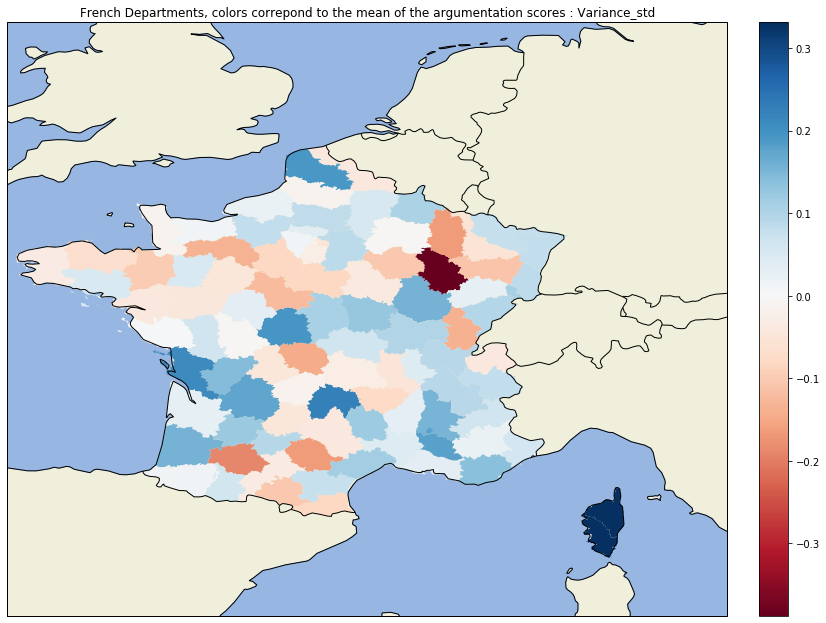

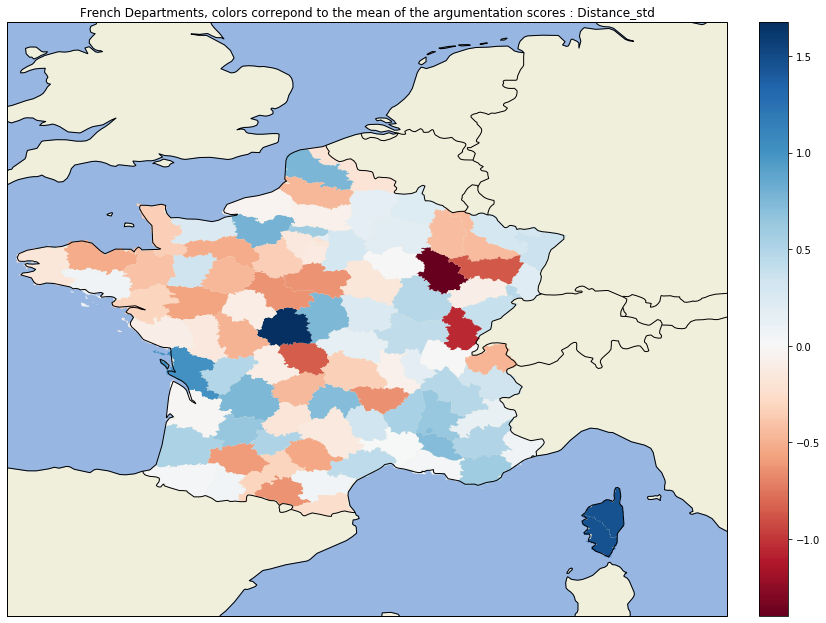

In [84]:
dpts = [k for k in range(1,21)] + [20] + [k for k in range(21,96)]
for eval_type in ['Variance_std','Distance_std']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=[k for k in range(96)], columns=['colors'])

    plot_cartography(Colors, eval_type, figsize=(14,14))